### YOLO dataset creator. 

YOLO is a segmentation network. [There is a colab notebook for finetuning it on your custom dataset](https://colab.research.google.com/drive/1YnbqOinBZV-c9I7fk_UL6acgnnmkXDMM#scrollTo=VyD5KHSUr5ow). Therefore I will make a dataset using the emnist characters. I will place the characters so that they look like the dataset, and store the images and the bounding boxes. This will be then used for finetuning. 

One potential issue is that this network will not take into account the number,letter,number... pattern. However lets see how it does. 

The network will identify characters and their bounding boxes. We can hopefully then look at the CoM of the boxes to determine the ID.


Add some noise to dataset, also do separate sets for letters and numbers.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import TensorDataset, DataLoader
from ML_helper import *
import h5py
from skimage.transform import rotate, resize, rescale
from PIL import Image
import cv2


by_merge_map = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q', 45:'r', 46:'t'}
relevant_characters =  {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'B',10:'F',11:'G',12:'K',13:'N',14:'O',15:'P',16:'R',17:'S',18:'V',19:'W',20:'Y'}
# numbers =  {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8'}
# letters =  {0:'B',1:'F',2:'G',3:'K',4:'N',5:'O',6:'P',7:'R',8:'S',9:'V',10:'W',11:'Y'} 

def convert_labels_to_relevant(labels, original_label_dict, new_label_dict):
    new_labels = np.zeros_like(labels)
    
    for n,label in enumerate(labels):
        char = original_label_dict[label]
        new_labels[n] = list(new_label_dict.values()).index(char)
    return new_labels

   

c:\Users\howards\Anaconda3\envs\torchenv\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


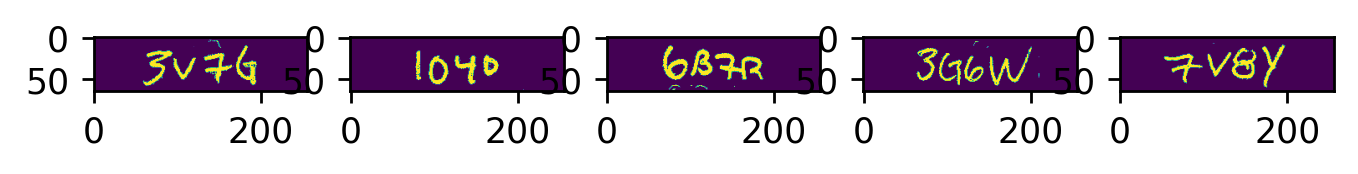

In [2]:
f = h5py.File('dataset.h5','r')
fig,ax = plt.subplots(1,5,dpi=250)
for i in range(5):
    ax[i].imshow(f['images'][i])

In [3]:
def flip_rotate(image):
    """ Flip ảnh và Xoay ảnh 90 độ ngược chiều kim đồng hồ"""

    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [105]:
no_images = 112800

labels = np.zeros((no_images), dtype=int)
images = np.zeros((no_images, 28, 28), dtype=int)

i=0
with open(r'\\alfs1.physics.ox.ac.uk\al\howards/emnist-balanced-train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    for row in csv_reader:
        labels[i] = int(row[0])
        images[i] = flip_rotate(np.array(row[1:],dtype=np.uint8).reshape((28,28)))
        i+=1
        if i==no_images:
            break

In [104]:
i

112800

In [106]:
def id_to_char(labels, keys_list):
    'convert the id into the corresponding character'
    labels = np.array(labels)
    return [keys_list[label] for label in labels]

def remove_irrelevants(images, labels, keys_list, relevant_characters,):
    

    key_list = list(keys_list.keys())
    val_list = list(keys_list.values())


    position = [val_list.index(relevant_characters[i]) for i in range(len(relevant_characters))] 
    idxs = [i in position for i in labels]
    return images[idxs], labels[idxs]

images, labels,  = remove_irrelevants(images, labels, by_merge_map, relevant_characters)

# images_let, labels_let = remove_irrelevants(images, labels, by_merge_map, letters)
# images_num, labels_num = remove_irrelevants(images, labels, by_merge_map, numbers)

# labels_let = convert

labels = convert_labels_to_relevant(labels, by_merge_map, relevant_characters)

images_num = images[labels<9]
labels_num = labels[labels<9]

images_let = images[labels>8]
labels_let = labels[labels>8]


In [188]:
def crop_nonzero(img):
    x, y = np.nonzero(img)
    xl,xr = x.min(),x.max()
    yl,yr = y.min(),y.max()
    return img[xl:xr+1, yl:yr+1]


def collate_chars(chars, img_size=(64,256), fourrows =False,  threshold=False):
    #take n characters and put them together into an image.
    
    img = np.zeros(img_size)

    word_start = np.random.randint(30,60)

    bounding_boxes = []

    if fourrows: charheight = img_size[0]//4
    else: charheight = img_size[0]

    position = word_start #np.arange(word_start, word_end)

    for n,char in enumerate(chars):

        char = char.astype(np.float32)

        if threshold!=False:
            char[char<char.max()*threshold] = 0
            char[char!=0] = 1

        char = crop_nonzero(char)

        char = rescale(char,  scale  =  np.random.rand(1)*0.5 + 1.5)

        bla = char.shape

        addition = np.random.randint(-1, 14)
        xcoord = position + addition

        position = position + bla[1] + addition

        ycoord = np.random.randint(1, charheight - bla[0] -2)

        bounding_box = [[ycoord,ycoord+bla[0]], [xcoord,xcoord+bla[1]]]
        bounding_boxes.append(bounding_box)

        img[bounding_box[0][0]:bounding_box[0][1],bounding_box[1][0]:bounding_box[1][1]] += char



    img = rotate(img, np.random.rand(1)[0]*5 - 2.5)

    if img.max() > 3:
        img[img>255] = 255
    else:
        img[img>1] = 1


    for i in range(10): #5 noise clusters
        xpos = np.random.randint(10, img_size[1] - 10)
        ypos = np.random.randint(10, img_size[0] - 10)
        xsize = np.random.randint(0, 3)
        ysize = np.random.randint(0, 3)
        img[ypos-ysize:ypos+ysize, xpos-xsize:xpos+xsize] = 1 #- img[ypos-ysize:ypos+ysize, xpos-xsize:xpos+xsize]

    img = img.astype(np.float32) 
    
    # if np.random.rand(1)[0] > 0.5:
    #     img = cv2.erode(img, np.ones((3,3),np.uint8), iterations=1)

    img = img/np.max(img)



    return img, bounding_boxes

    


[[[13, 46], [38, 50]], [[6, 46], [56, 87]], [[13, 50], [99, 129]], [[11, 34], [132, 168]]]


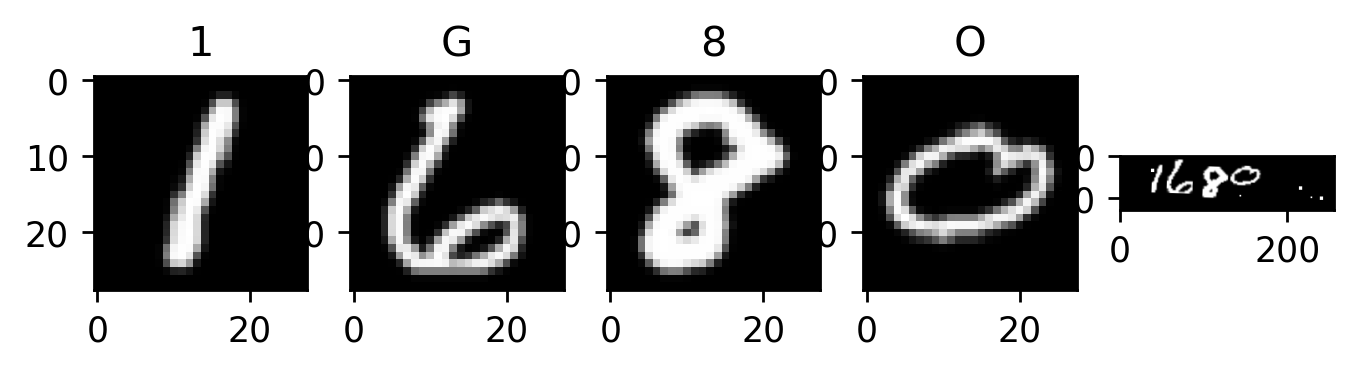

In [211]:
%matplotlib inline

n = np.random.randint(0,700)

chars = np.concatenate([images_num[n:n+1], images_let[n:n+1],images_num[n+1:n+2], images_let[n+1:n+2]])#, images_num[n+2:n+3]])
labels_ = np.concatenate([labels_num[n:n+1], labels_let[n:n+1],labels_num[n+1:n+2], labels_let[n+1:n+2]])#, labels_num[n+2:n+3]])
char_labels = id_to_char(labels_, keys_list=relevant_characters)

fig,ax = plt.subplots(1,5,dpi=250)

for i in range(4):
    ax[i].imshow(chars[i], cmap='gray')
    ax[i].set_title(str(char_labels[i]))


img, boundingbox = collate_chars(chars,threshold=0.5)


ax[-1].imshow(img, cmap='gray')
print(boundingbox)

In [212]:
def make_text_file(labels, exampleno, boundingbox, imgsize = [64,256],prefix = '../YOLOdata/labels/train/'):
    # class_id center_x center_y bbox_width bbox_height

    with open(prefix + f'im{exampleno}.txt', 'w') as f:
        
        for i in range(len(labels)):
            

            center_x = (boundingbox[i][0][0] + boundingbox[i][0][1])/2
            bbox_width = boundingbox[i][0][1] - boundingbox[i][0][0]
            center_x = center_x/imgsize[0]
            bbox_width = bbox_width/imgsize[0]

            center_y = (boundingbox[i][1][0] + boundingbox[i][1][1])/2
            bbox_height = boundingbox[i][1][1] - boundingbox[i][1][0]
            center_y = center_y/imgsize[1]
            bbox_height = bbox_height/imgsize[1]
        
            f.write(f'{labels[i]} {center_y} {center_x} {bbox_height} {bbox_width}\n')

In [213]:
# make_text_file(labels_, 0, boundingbox)

## Now we have everything we need to make the dataset.

In [214]:
no_samples = np.min([len(labels_num), len(labels_let), 20000])

In [215]:
exno = 0

lets_prefix = '../YOLOdata/letters/'
nums_prefix = '../YOLOdata/numbers/'

for n in np.arange(0,no_samples,2):

    chars = np.concatenate([images_num[n:n+1], images_let[n:n+1],images_num[n+1:n+2], images_let[n+1:n+2]])
    labels_nums = np.concatenate([labels_num[n:n+1], labels_num[n+1:n+2]]) 
    labels_lets = np.concatenate([labels_let[n:n+1], labels_let[n+1:n+2]]) - 9 #0 to 8

    try:
        img, boundingbox = collate_chars(chars,threshold=0.5)

        boundingbox_nums = boundingbox[::2]
        boundingbox_lets = boundingbox[1::2]

        img = (((img - img.min()) / (img.max() - img.min())) * 255.9)

        img = Image.fromarray(np.uint8(img))
        img = img.convert("L")

        
        img.save(lets_prefix + f"im{exno}.jpg")
        img.save(nums_prefix + f"im{exno}.jpg")

        
        make_text_file(labels_lets, exno, boundingbox_lets, imgsize = [64,256], prefix = lets_prefix)
        make_text_file(labels_nums, exno, boundingbox_nums, imgsize = [64,256], prefix = nums_prefix)
        exno += 1
    except:
        pass



        

(array([5, 7]), array([4, 4]))

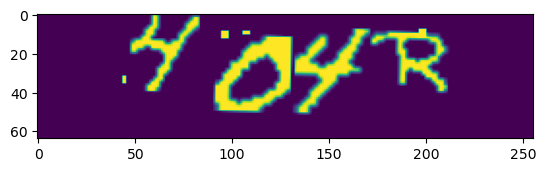

In [216]:
plt.imshow(img)
labels_lets, labels_nums 



In [217]:
bla = np.array(img.getdata()).reshape(img.size[1], img.size[0])


['1', 'G', '8', 'O']


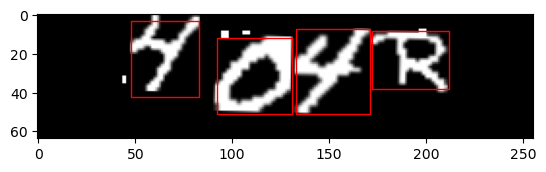

In [218]:

plt.imshow(bla, cmap='gray')

print(id_to_char(labels_, keys_list=relevant_characters))
import matplotlib.patches as patches
ax = plt.gca()
for i in boundingbox:

    width = i[1][1] - i[1][0]
    height = i[0][1] - i[0][0]
    rect = patches.Rectangle((i[1][0], i[0][0]), width, height, linewidth=1, edgecolor='r', facecolor='None')
    


    ax.add_patch(rect)


plt.show()
